# POC: Get data and use case

 
- Source for use case 1: https://aclanthology.org/2021.newsum-1.9.pdf

In [1]:
import requests
from dotenv import load_dotenv
import pandas as pd
import os
pd.options.display.max_columns = 999


load_dotenv()


# note that CLIENT_ID refers to 'personal use script' and SECRET_TOKEN to 'token'
auth = requests.auth.HTTPBasicAuth(os.environ.get("NAME"), os.environ.get("SECRET"))

# here we pass our login method (password), username, and password
data = {'grant_type': 'password',
        'username': os.environ.get("USERNAME"),
        'password': os.environ.get("PASSCOMPTE")}

# setup our header info, which gives reddit a brief description of our app
headers = {'User-Agent': 'MyBot/0.0.1'}

# send our request for an OAuth token
res = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth, data=data, headers=headers)

# convert response to JSON and pull access_token value
TOKEN = res.json()['access_token']

# add authorization to our headers dictionary
headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}



## A - Request post from reddit API

### A.1 - Get the "hot" post from AITAH community 

In [2]:
columns = ["title", "selftext", "link_flair_text", "ups", "downs", "num_comments", "created", "edited", "author", "permalink"]

data = requests.get('https://oauth.reddit.com/r/AITAH/hot', headers=headers, params={'limit':'50'}).json()["data"]["children"]
data = pd.json_normalize(data)
data.columns = [c.replace("data.", "") for c in data.columns]  
posts = data[columns]

posts["num_words"] = posts.selftext.map(lambda x: len(x.split(" ")))

/tmp/ipykernel_7303/3233183505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts["num_words"] = posts.selftext.map(lambda x: len(x.split(" ")))


In [3]:
from tqdm import tqdm


ACRONYM = ["YTA", "YWBTA", "NTA", "YWNBTA", "ESH", "NAH", "INFO"]

import re
def get_acronym(doc):
    for a in ACRONYM:
        if re.search(a, doc):
            return a
    return None

labels_post = []

for post_url in tqdm(posts.permalink):

    comments = requests.get('https://oauth.reddit.com'+post_url, headers=headers, params={'limit':'10000'}).json()
    comments = pd.json_normalize(comments[1]["data"]["children"])
    comments.columns = [c.replace("data.", "") for c in comments.columns] 
    comments = comments[~comments.body.isna()]
    labels_post.append(comments.body.map(get_acronym).value_counts())

posts = pd.concat([posts, pd.concat(labels_post, axis=1).T.reset_index().drop(columns=["index"])], axis=1)

100%|██████████| 51/51 [01:34<00:00,  1.86s/it]


### A.2 - Get the comment from a post of AITAH community

Get data from 0 levels

In [4]:
from pprint import pprint
r = iter(range(20))

In [5]:
posts[['NTA', "YTA"]]

,NTA,YTA
0,8.0,4.0
1,47.0,NaN
2,120.0,1.0
3,256.0,NaN
4,203.0,NaN
5,89.0,NaN
6,52.0,2.0
7,88.0,1.0
8,3.0,1.0
9,166.0,4.0


In [7]:
i = 42
post = posts.loc[i]
post_url = posts.permalink[i]
print(i, post_url, posts.num_comments[i])
pprint(posts.selftext[i])

42 /r/AITAH/comments/1dp8hwy/aita_for_telling_my_girlfriend_i_never_want_to/ 372
('I (23M) dating my girlfriend, Anna (25F), and we’ve been together for almost '
 'two years now. Our relationship has always been great, and we’re pretty open '
 'with each other about our feelings and future plans. Recently, we were '
 'hanging out with some friends, and the topic of marriage came up. When we '
 'got home, Anna asked me what I thought about getting married, and I told her '
 'honestly that I never want to.\n'
 '\n'
 'To give some context, I come from a family where marriages haven’t really '
 'worked out well. My parents got divorced when I was young, and most of my '
 'relatives have had pretty rocky relationships. Because of this, I’ve '
 'developed a pretty negative view of marriage. I explained all of this to '
 'Anna, thinking she’d understand where I was coming from.\n'
 '\n'
 'But she got really upset. She said she always dreamed of getting married '
 'someday and that it’s really

In [8]:
comments = requests.get('https://oauth.reddit.com'+post_url, headers=headers, params={'limit':'10000'}).json()

comments = pd.json_normalize(comments[1]["data"]["children"])
comments.columns = [c.replace("data.", "") for c in comments.columns] 

columns_reduced = ['subreddit_id', 'author_is_blocked',
       'author_flair_type', 'replies.children', 'id', 'author',
       'created_utc', 'body', 'downs', 'ups']

comments = comments[columns_reduced]
comments = comments[~comments.body.isna()]

---

## B - Possible uses cases 

## Use Case 1: Sentence Similarity

**Aim:** Discover the similarity between sentences to group them by opinion (may require fine-tuning).  
**Data:** Comments from each post  
**Model:** [Paraphrase-Multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2)

In [9]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns


ACRONYM = ["YTA", "YWBTA", "NTA", "YWNBTA", "ESH", "NAH", "INFO"]

import re
def get_acronym(doc):
    for a in ACRONYM:
        if re.search(a, doc):
            return a
    return None

comments['label_user'] = comments.body.map(get_acronym)

torch.cuda.is_available()

/home/romain/anaconda3/envs/projet/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

/home/romain/anaconda3/envs/projet/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<Axes: >

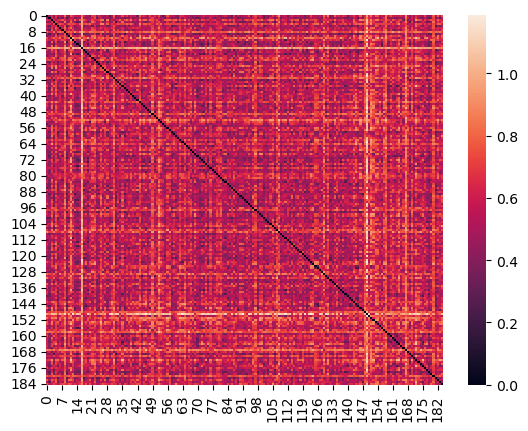

In [10]:
cos_dist = sc.spatial.distance.cosine
sentences = comments.body.to_list()

model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(sentences)

matrix = [[cos_dist(e1, e2) for e1 in embeddings] for e2 in embeddings]

sns.heatmap(matrix)

<Axes: >

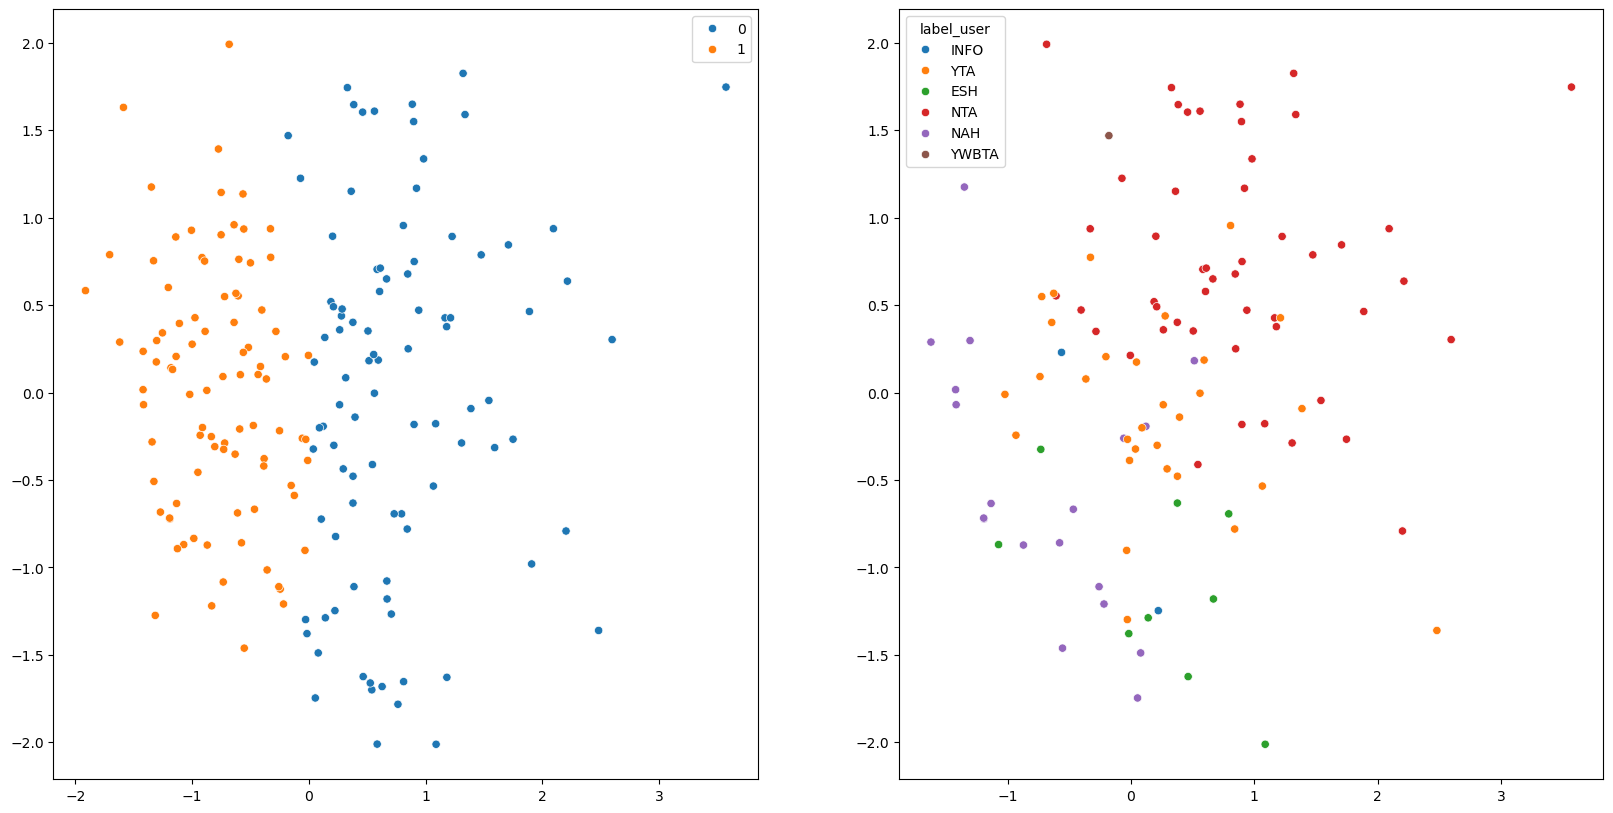

In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import seaborn as sns


pca = PCA(n_components=2)
pca = pca.fit(embeddings)
features = pca.transform(embeddings)

db = GaussianMixture(tol=0.001, n_components=2)

pred = db.fit_predict(features)


comments[pred == 1]

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=pred)

plt.subplot(1, 2, 2)

sns.scatterplot(x=features[:, 0], y=features[:, 1], hue = comments.label_user)

In [12]:
import os
from pathlib import Path
os.makedirs("./data", exist_ok=True)
os.makedirs("./data/raw", exist_ok=True)
def make_dir(i, post, comments):
    os.makedirs(f"./data/raw/post_{i}", exist_ok=True)
    with open(f"./data/raw/post_{i}/post.json", mode="w") as f:
        f.write(post.to_json())
    comments.to_pickle(f"./data/raw/post_{i}/comments.pkl")

post_path_data = list(Path("./data/raw").glob('post_*'))
if len(post_path_data) == 0:
    make_dir(0, post, comments)
else:
    i = max([p.name.replace("post_", "") for p in post_path_data]) + 1
    make_dir(i, post, comments)

## Use Case 2: Emotion Detection of Posts

**Aim:** Detect the general emotion in each post  
**Data:** Posts from AITAH  
**Model:** [Emotion-English-DistilRoBERTa-Base](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base)

In [41]:
from transformers import pipeline
from tqdm import tqdm
import numpy as np

classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

labels = []
for title in tqdm(posts.title):
    
    labels_post = classifier(title)
    list_label_post = []
    for detail_label in labels_post[0]:
        if detail_label["score"] > 0.20: ## TODO: Threshold not analysied
            list_label_post.append(detail_label["label"])
    labels.append(list_label_post)

labels = pd.Series(labels, name="label")

/home/romain/anaconda3/envs/projet/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/romain/anaconda3/envs/projet/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 51/51 [00:02<00:00, 24.41it/s]


In [43]:
classified_posts = pd.concat((posts, labels), axis=1)
classified_posts[["title", "selftext", "label"]]

,title,selftext,label
0,r/AITAH Lounge,A place for members of r/AITAH to chat with ea...,[neutral]
1,AITAH for breaking up with my girlfriend when ...,When I was 16 years old my girlfriend broke up...,[fear]
2,AITA for kicking my husband out of the house a...,"I (28F) have been married to my husband, Steve...",[disgust]
3,AITAH for approaching women at the bar while m...,My wife (35f) and I (36m) went to a bar last w...,[disgust]
4,AITAH for not giving my wife the full reason t...,My wife and I have been discussing baby names ...,"[anger, disgust]"
5,Family forgot I was a Father.,"\nSo, literally, both kids and my wife, all wh...","[neutral, sadness, surprise]"
6,AITAH for refusing to change items on my dinne...,I will try to keep this short. We are having a...,"[anger, neutral, surprise]"
7,AITA for putting in a claim to my late father’...,[Original post](https://www.reddit.com/r/AITAH...,"[anger, neutral, sadness]"
8,AITAH for not wanting a baby girl so my MIL wo...,I 28(F) am pregnant and about to deliver our f...,"[sadness, surprise]"
9,AITAH for not spending Father’s Day with my wi...,I (34M) have been married to my wife (32F) for...,"[anger, disgust, surprise]"


In [50]:
from pprint import pprint
pprint(classified_posts.iloc[36].title)

('AITAH for telling my boyfriend if he doesn’t want to have sex with me, then '
 'we need to break up? ')
